In [ ]:
Team 10

In [247]:
#loading the important libraries for Exploratory Data Ananlysis.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
!pip install mlxtend
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth


In [174]:
#reading the dataset
brain = pd.read_csv("data/brain_stroke.csv")
brain.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [175]:
#shape of the data
brain.shape

(4981, 11)

In [176]:
#checking for NA values in the dataset
brain.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [177]:
#checking basic info about the data-set
brain.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [178]:
# Now, we will try to convert the categorical data into binary data which will help us in visualizing on the data well and it will computationally less expensive for us when we try to train our models on this dataset.

In [179]:
brain["gender"].unique() #checking the unique values in the column "gender"
# Here, Male can be mapped to 1 and Female can be mapped to 0.

array(['Male', 'Female'], dtype=object)

In [180]:
brain["gender"] = brain["gender"].map({"Male":1, "Female":0})

In [181]:
#Similarly, we will check for other columns!

In [182]:
brain["work_type"].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children'], dtype=object)

In [183]:
brain["Residence_type"].unique()

array(['Urban', 'Rural'], dtype=object)

In [184]:
# Convert them as Urban = 1 and Rural as 0
brain["Residence_type"] = brain["Residence_type"].map({"Urban":1, "Rural":0})

In [185]:
brain["ever_married"].unique()

array(['Yes', 'No'], dtype=object)

In [186]:
# Yes can be mapped to 1 and no can be mapped to 0.
brain["ever_married"] = brain["ever_married"].map({"Yes":1, "No":0})

In [187]:
brain.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,1,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
2,0,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
3,0,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
4,1,81.0,0,0,1,Private,1,186.21,29.0,formerly smoked,1


In [188]:
brain["smoking_status"].unique()
#We have identified that the "smoking_status" column has four unique values, including "Unknown." It is prudent to exclude rows with unknown smoking status from our model training since predicting outcomes for individuals without smoking status information lacks meaningful input. Additionally, retaining such unknown values might introduce noise and compromise the model's predictive accuracy, emphasizing the importance of removing these instances.As Four unique values are present, we can't change it to Binary values. Thus we will leave it as it is.

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [189]:
# #counting the number of Unknowns in the "smoke_staus"
unknown_count = brain['smoking_status'].value_counts().get('Unknown', 0)
print(f"Number of 'Unknown' in smoking_status: {unknown_count}")

Number of 'Unknown' in smoking_status: 1500


In [190]:
# We will now remove these 1500 rows!
brain = brain[brain['smoking_status'] != 'Unknown']

# Resetting the index
brain.reset_index(drop=True, inplace=True)
brain["smoking_status"].unique()

array(['formerly smoked', 'never smoked', 'smokes'], dtype=object)

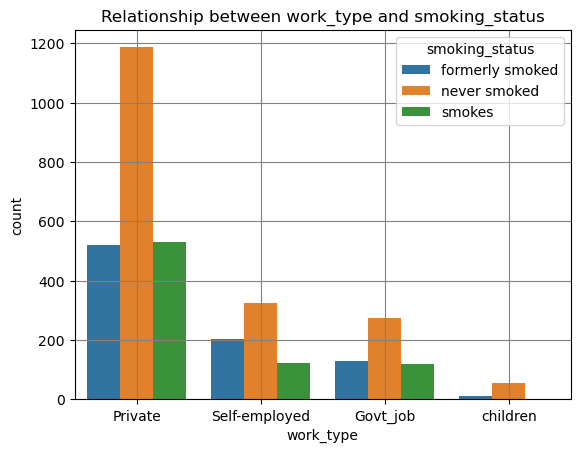

In [191]:
plt.figure()
sns.countplot(x='work_type', hue='smoking_status', data=brain)
plt.title('Relationship between work_type and smoking_status')
plt.grid(color = "gray")
plt.show()

In [192]:
# The bar chart depicts the correlation between 'work_type' and 'smoking_status'. It features four bars (private, self-employed, government, and children), each divided into three sections (smokes, formerly smoked, and never smoked). The y-axis represents the count of individuals, while the x-axis represents work types. Notably, individuals in the private sector are more likely to smoke, with approximately 500 people, and have almost equal incidence of past smoking compared to other sectors. Self-employed and government workers show lower smoking counts and a proportionally smaller "formerly smoked" segment. Children exhibit the least smoking prevalence.

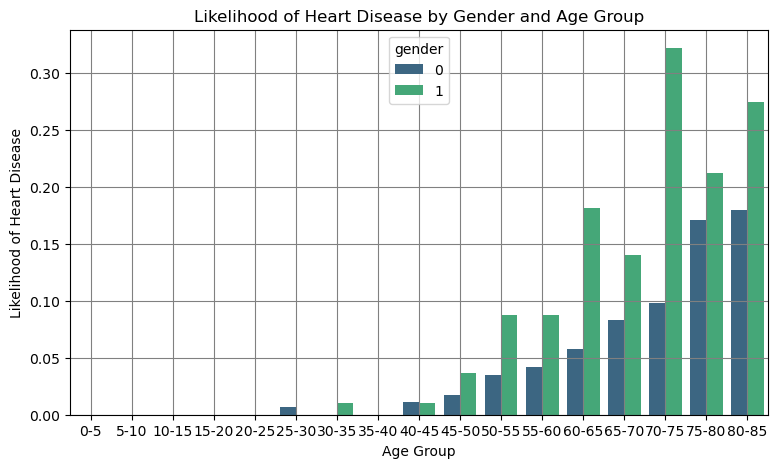

In [193]:
bins = range(0, int(brain['age'].max()) + 6, 5)
labels = [f'{start}-{end}' for start, end in zip(bins[:-1], bins[1:])]
brain['age_group'] = pd.cut(brain['age'], bins=bins, labels=labels, right=False)

# Grouping by 'gender' and 'age_group' and calculating the mean of 'heart_disease'
grouped_data = brain.groupby(['gender', 'age_group'])['heart_disease'].mean().reset_index()

# Creating a bar plot
plt.figure(figsize=(9, 5))
sns.barplot(x='age_group', y='heart_disease', hue='gender', data=grouped_data, palette='viridis')
plt.title('Likelihood of Heart Disease by Gender and Age Group')
plt.xlabel('Age Group')
plt.ylabel('Likelihood of Heart Disease')
plt.grid(color = "gray")
plt.show()

In [194]:
# The graph shows that the likelihood of heart disease increases with age for both males and females, but it is higher for males than for females at all ages. The likelihood of heart disease is also highest for males in the 70-75 age group and for females in the 80-85 age group.

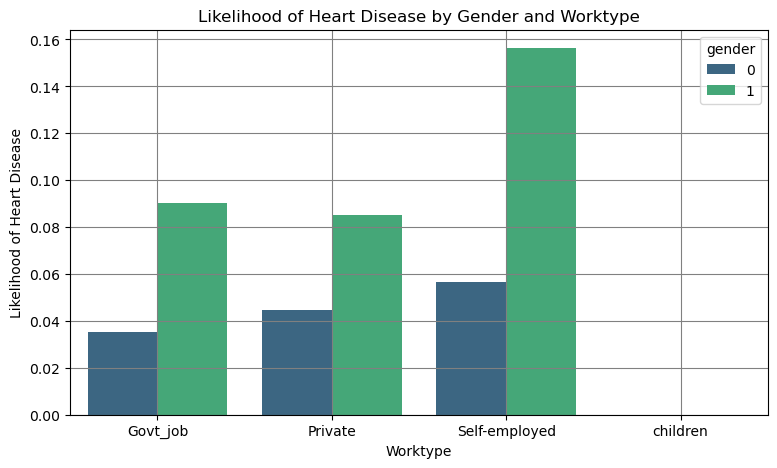

In [195]:
grouped_data = brain.groupby(['gender', 'work_type'])['heart_disease'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(9, 5))
sns.barplot(x='work_type', y='heart_disease', hue='gender', data=grouped_data, palette='viridis')
plt.title('Likelihood of Heart Disease by Gender and Worktype')
plt.xlabel('Worktype')
plt.ylabel('Likelihood of Heart Disease')
plt.grid(color = "gray")
plt.show()

In [196]:
# The graph shows that the likelihood of heart disease is higher for people who are self-employed than for people who work in government jobs or private sector jobs. The likelihood of heart disease is also higher for males than for females in all work types.

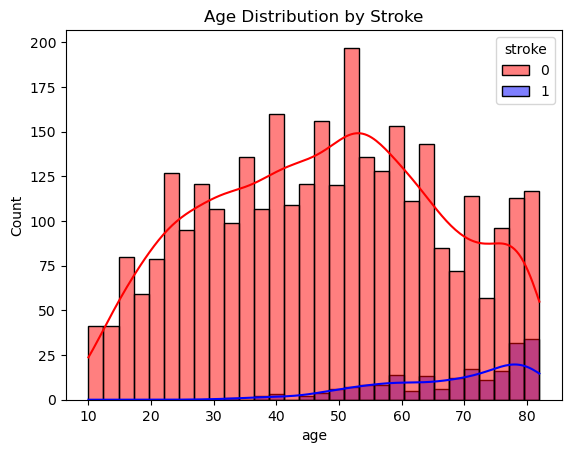

In [197]:
plt.figure()
sns.histplot(x='age', hue='stroke', data=brain, kde=True, bins=30, palette=['red', 'blue'])
plt.title('Age Distribution by Stroke')

plt.show()

In [198]:
# The plot shows that the age distribution of stroke patients is skewed to the right, meaning that there are more older stroke patients than younger stroke patients. The median age of stroke patients in the dataset is 65 years old. Patients with a history of stroke are also more likely to be older than patients without a history of stroke.

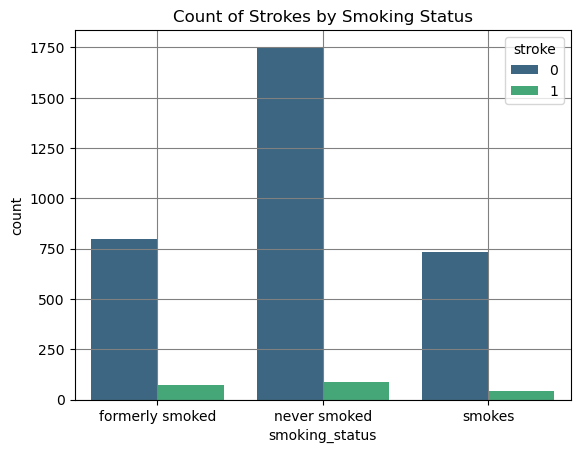

In [199]:
sns.countplot(x='smoking_status', hue='stroke', data=brain, palette='viridis')
plt.title('Count of Strokes by Smoking Status')
plt.grid(color = "gray")
plt.show()

In [200]:
# It's unexpected to observe that the likelihood of experiencing a stroke is not much influenced by an individual's smoking status. Despite this, it can be deduced that individuals who have never smoked exhibit a lower susceptibility to stroke.

C:\Users\Nikitha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


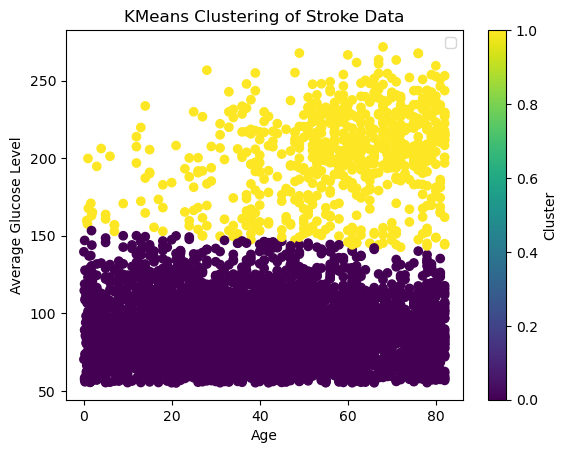

In [234]:
# Performing K-mean Clustering

file_path = 'data/brain_stroke.csv'

# Read the CSV file
data = pd.read_csv(file_path)

data = pd.get_dummies(data, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

# Scale numerical values
# scaler = StandardScaler()
# numerical_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
# data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Focus on stroke column for clustering
X = data.drop('stroke', axis=1)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # You can adjust the number of clusters
data['cluster'] = kmeans.fit_predict(X)

# Visualize clusters
plt.scatter(data['age'], data['avg_glucose_level'], c=data['cluster'], cmap='viridis')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level')
plt.title('KMeans Clustering of Brain Stroke Data')

# Adding legend
plt.colorbar(label='Stroke')
plt.legend(handles=[], labels=["Cluster 0", "Cluster 1", "Cluster 2"])  # Add labels for clusters
plt.show()


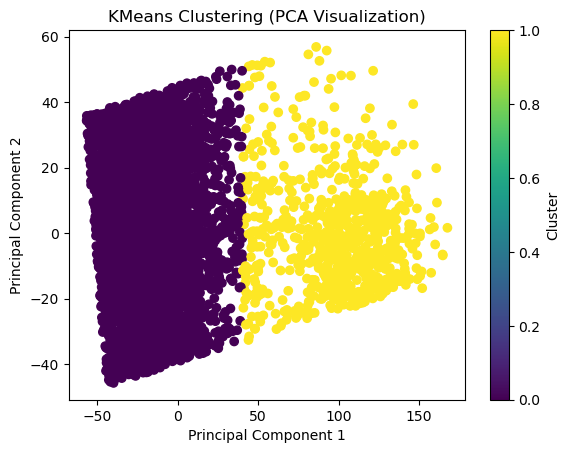

In [235]:
# Use PCA to reduce dimensions for visualization (2D)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Visualize clusters in 2D
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=data['cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering (PCA Visualization)')

# Create legend handles and labels
# legend_labels = [f'Cluster {i}' for i in range(len(set(data["cluster"])))]
# plt.legend(handles=plt.scatter.legend_elements()[0], labels=legend_labels)

plt.colorbar(label='Stroke')
plt.show()

In [246]:
# Association Rule Mining

# Copying the dataset to new variable to perform apriori

brain_stroke_copy = brain.copy()
brain_stroke_copy.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,1,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1,65-70
1,1,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1,80-85
2,0,49.0,0,0,1,Private,1,171.23,34.4,smokes,1,45-50
3,0,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1,75-80
4,1,81.0,0,0,1,Private,1,186.21,29.0,formerly smoked,1,80-85


In [237]:
# Mapping numerical values of 'hypertension' column to categorical labels
brain_stroke_copy['hypertension'] =brain_stroke_copy['hypertension'].map({0: 'No Hypertension', 1: 'Hypertension'})
# brain['hypertension'] = brain['hypertension'].astype('category')


In [238]:
brain_stroke_copy.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,1,67.0,No Hypertension,1,1,Private,1,228.69,36.6,formerly smoked,1,65-70
1,1,80.0,No Hypertension,1,1,Private,0,105.92,32.5,never smoked,1,80-85
2,0,49.0,No Hypertension,0,1,Private,1,171.23,34.4,smokes,1,45-50
3,0,79.0,Hypertension,0,1,Self-employed,0,174.12,24.0,never smoked,1,75-80
4,1,81.0,No Hypertension,0,1,Private,1,186.21,29.0,formerly smoked,1,80-85


In [239]:
brain_stroke_copy['heart_disease'].fillna(0, inplace=True)
brain_stroke_copy['heart_disease'] = brain_stroke_copy['heart_disease'].map({0: 'No Heart Disease', 1: 'Heart Disease'})
# brain['heart_disease'] = brain['heart_disease'].astype('category')

In [250]:
brain_stroke_copy.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,1,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1,65-70
1,1,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1,80-85
2,0,49.0,0,0,1,Private,1,171.23,34.4,smokes,1,45-50
3,0,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1,75-80
4,1,81.0,0,0,1,Private,1,186.21,29.0,formerly smoked,1,80-85


In [251]:
# Select columns for association
association_data = brain_stroke_copy[['hypertension', 'heart_disease', 'smoking_status']]

# Applying one-hot encoding to convert categorical variables to binary indicators
association_data_encoded = pd.get_dummies(association_data)

# Applying Apriori Algorithm
frequent_itemsets = apriori(association_data_encoded, min_support=0.1, use_colnames=True)

# Generating association rules for the given data
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
print(rules)
print(frequent_itemsets)

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []
    support                          itemsets
0   0.12324                    (hypertension)
1  0.249066  (smoking_status_formerly smoked)
2  0.528009     (smoking_status_never smoked)
3  0.222924           (smoking_status_smokes)


C:\Users\Nikitha\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [248]:
# Generating frequent itemsets using FP-Growth algorithm 

# Selecting required columns for FP-Growth
association_data = brain_stroke_copy[['hypertension', 'heart_disease', 'smoking_status']]

# Applying one-hot encoding to convert categorical variables to binary indicators
association_data_encoded = pd.get_dummies(association_data)

# Applying FP-Growth algorithm
frequent_itemsets = fpgrowth(association_data_encoded, min_support=0.1, use_colnames=True)

# Print the result
print(frequent_itemsets)

    support                          itemsets
0  0.249066  (smoking_status_formerly smoked)
1  0.528009     (smoking_status_never smoked)
2  0.222924           (smoking_status_smokes)
3  0.123240                    (hypertension)


C:\Users\Nikitha\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
